**Importing Modules:**

In [190]:
import pathlib
from pathlib import Path
from typing import final

from scipy.io.wavfile import read
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf


from tensorflow.keras.layers import Rescaling, Normalization, TextVectorization
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Normalization, Resizing



import os
from typing import List


Variables:

In [191]:
fs: int = 22050;
categories: List[str] = ["red", "blue", "off"]

- **Visualizing Raw Wave files Data:**

Text(0.5, 1.0, 'Audio: Blue')

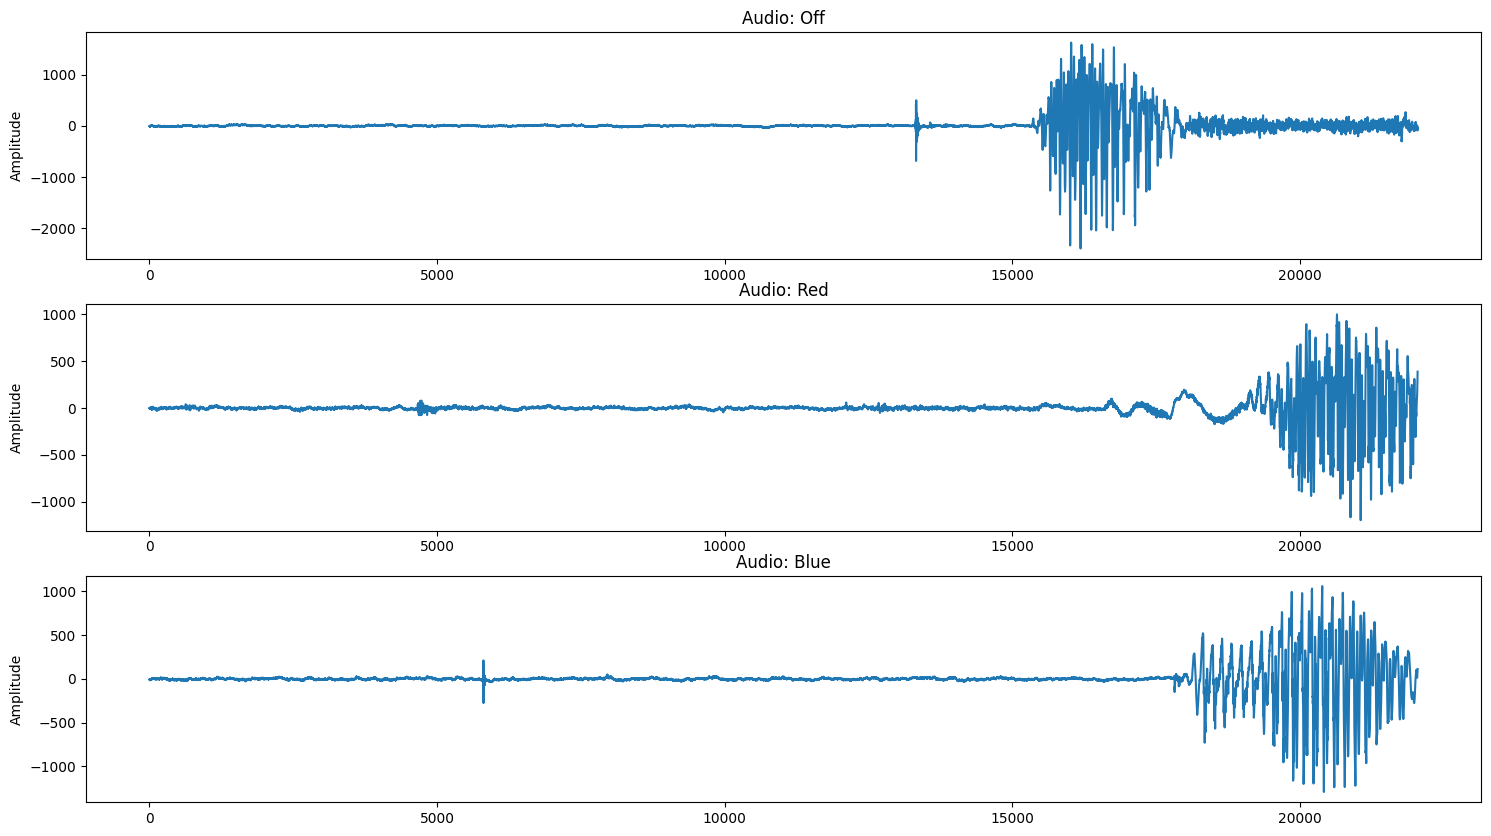

In [192]:

off_wav_file = read('./data/off_0.wav')
red_wav_file = read('./data/red_0.wav')
blue_wav_file = read('./data/blue_0.wav')

off_wav_file = off_wav_file[1]
red_wav_file = red_wav_file[1]
blue_wav_file = blue_wav_file[1]

wavefile_plotter = plt.figure(figsize=(18, 10))
off_plot = wavefile_plotter.add_subplot(311)
red_plot = wavefile_plotter.add_subplot(312)
blue_plot = wavefile_plotter.add_subplot(313)

off_plot.plot(off_wav_file)
off_plot.set_ylabel('Amplitude')
off_plot.set_title('Audio: Off')

red_plot.plot(red_wav_file)
red_plot.set_ylabel('Amplitude')
red_plot.set_title('Audio: Red')

blue_plot.plot(blue_wav_file)
blue_plot.set_ylabel('Amplitude')
blue_plot.set_title('Audio: Blue')

**Getting paths of wave files via their labels:**

In [193]:
data_dir: Path = pathlib.Path('data');

labels = np.array(tf.io.gfile.listdir(str(data_dir)))

audio_files_via_path: list[str] = tf.io.gfile.glob('data/*')

audio_path_files = tf.random.shuffle(audio_files_via_path)



Preprocessing data

In [194]:
import tensorflow as tf
import os

def extract_label(file_path: tf.Tensor) -> tf.Tensor:
    file_name = tf.strings.split(file_path, os.path.sep)[-1]
    label_of_file = tf.strings.split(file_name, "_")[0]
    return label_of_file

def path_to_tensor_beside_label(file_path: tf.Tensor) -> (tf.Tensor, tf.Tensor):
    label_of_file = extract_label(file_path)
    file_tensor = tf.io.read_file(file_path)
    audio_tensor, _ = tf.audio.decode_wav(file_tensor)
    audio_tensor = tf.squeeze(audio_tensor, axis=-1)
    return audio_tensor, label_of_file

data_tf_pipeline = tf.data.Dataset.from_tensor_slices(audio_path_files)
labeled_waveform_dataset = data_tf_pipeline.map(path_to_tensor_beside_label)





Visualizing Dataset:

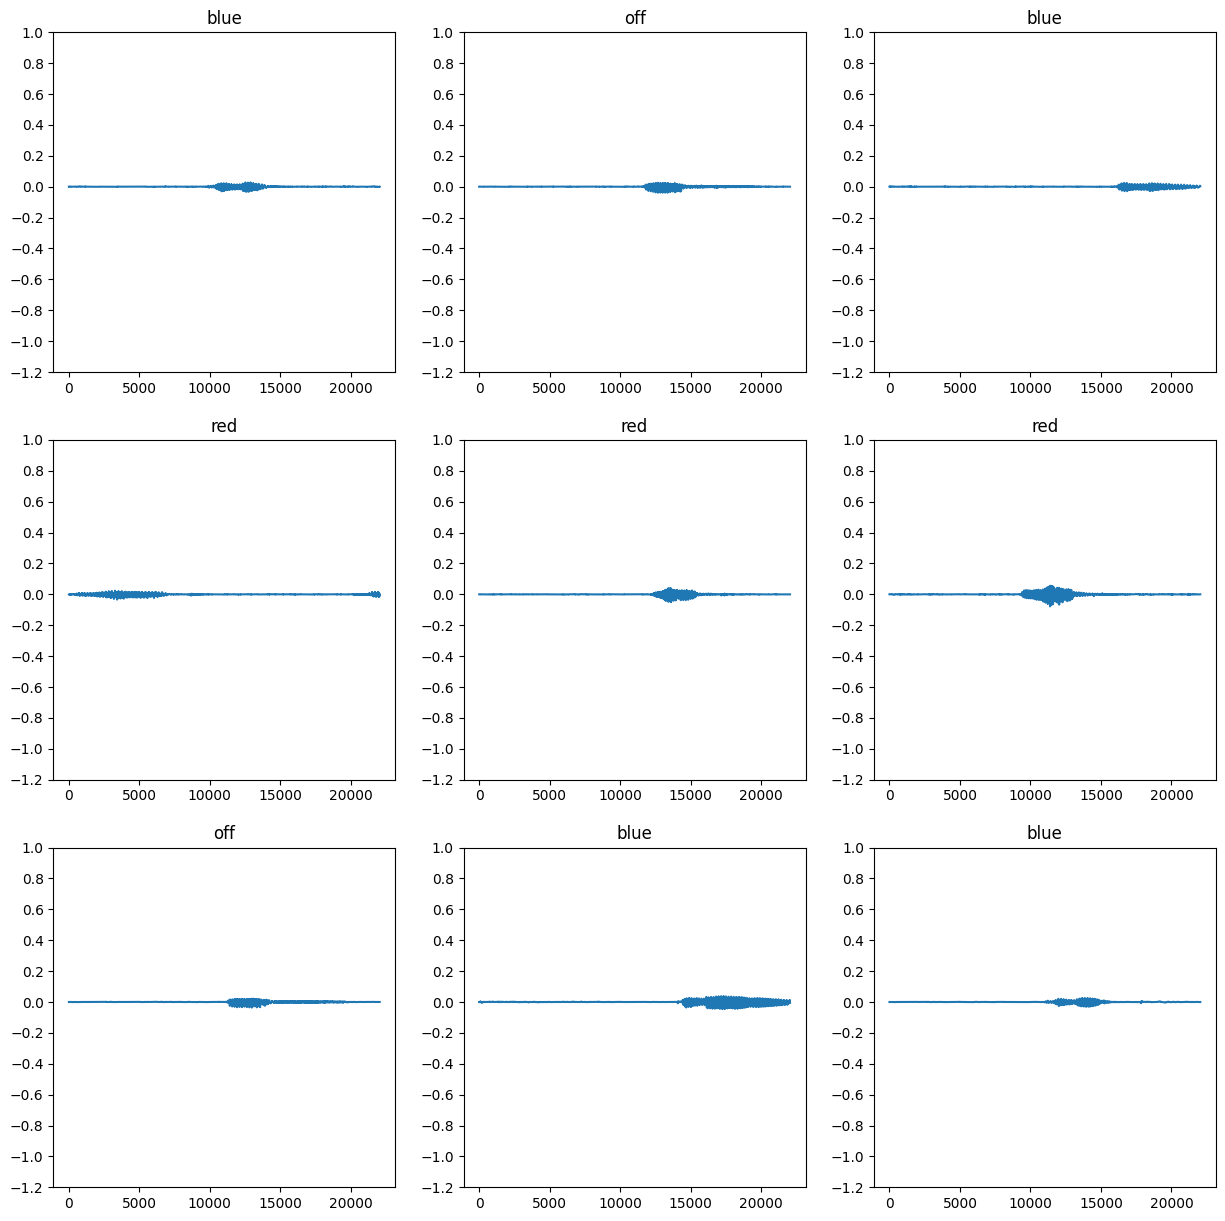

In [195]:
rows: int = 3
cols: int = 3
n: int = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for i, (audio, label) in enumerate(labeled_waveform_dataset.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()


Spectogram Conversation

In [196]:
waveform, label = labeled_waveform_dataset.take(1).get_single_element();
spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
spectrogram = tf.abs(spectrogram)
spectrogram = spectrogram[..., tf.newaxis]
label = label.numpy().decode('utf-8')

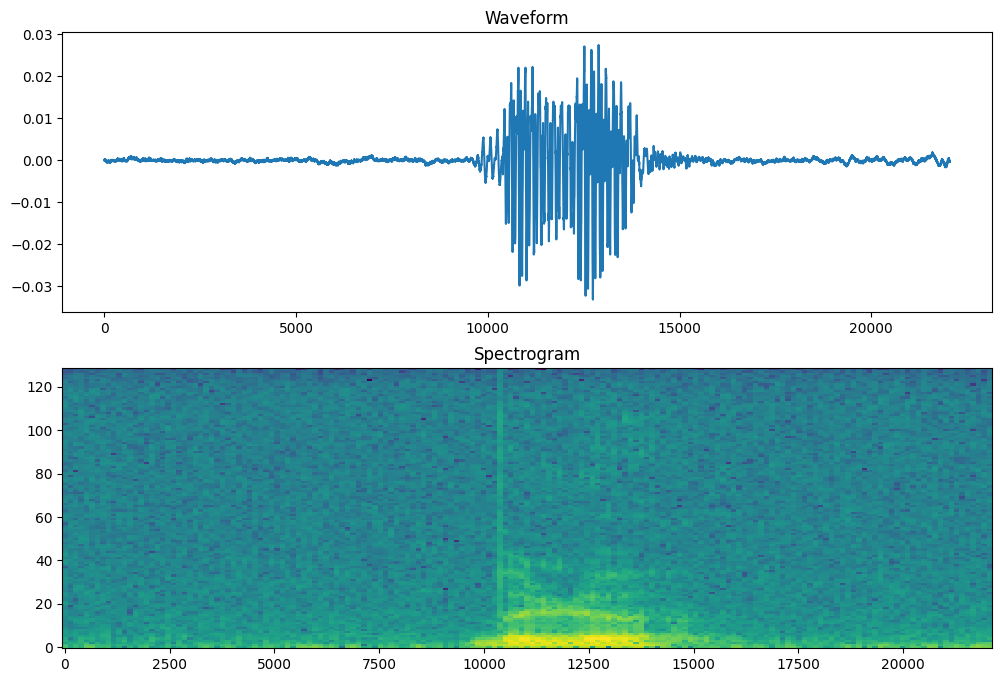

In [197]:
from numpy import float64


def plot_spectrogram(spectrogram_param: np.ndarray | tf.Tensor, ax_param: plt.axes):
    eps: float64 = np.finfo(float).eps;

    if len(spectrogram_param.shape) > 2:
        assert len(spectrogram_param.shape) == 3
        spectrogram_param = np.squeeze(spectrogram_param, axis=-1)
    log_spec = np.log(spectrogram_param.T + eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    x = np.linspace(0, np.size(spectrogram_param), num=width, dtype=int)
    y = range(height)
    ax_param.pcolormesh(x, y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

**Splitting Data into:**
 - Training 0.6
 - Testing 0.2
  - Validation 0.2

In [198]:
from typing import Final
from tensorflow.python.types.data import DatasetV2

TRAIN_RATIO: Final[float] = 0.6
TEST_RATIO: Final[float] = 0.2
VALIDATION_RATIO: Final[float] = 0.2

n: int = len(audio_files_via_path)
train_size: int = int(TRAIN_RATIO * n)
test_size: int = int(TEST_RATIO * n)
validation_size: int = int(VALIDATION_RATIO * n)

training_dataset_waveform: DatasetV2 = labeled_waveform_dataset.take(train_size)  # 60% of dataset
test_dataset_waveform: DatasetV2 = labeled_waveform_dataset.skip(train_size).take(test_size)  # 20% of dataset
validation_dataset_waveform: DatasetV2 = labeled_waveform_dataset.skip(train_size + test_size).take(
    validation_size)  # 20% of

for wave, label in test_dataset_waveform:
    print(label)

tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'red', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'off', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
tf.Tensor(b'off', shape=(),

Converting Wave paths to labeled Spectograms

In [199]:
import signal
from tensorflow.python.types.data import DatasetV2


def stft(waveform_par: tf.Tensor) -> tf.Tensor:
    spectrogram_var = tf.signal.stft(waveform_par, frame_length=255, frame_step=124, fft_length=256)
    spectrogram_var = tf.abs(spectrogram_var)
    return spectrogram_var

def waveforms_to_spectrogram(waveform_par: tf.Tensor, label_par: tf.Tensor):
    spectrogram_var = stft(waveform_par)

    spectrogram_shape = tf.shape(spectrogram_var)
    spectrogram_var = tf.reshape(spectrogram_var,(spectrogram_shape[0], spectrogram_shape[1]))
    spectrogram_var = tf.expand_dims(spectrogram_var, axis=0)
    label_par = tf.math.argmax(label_par == categories)
    return spectrogram_var, label_par




def convert_waveform_to_spectrogram(dataset_waveform: DatasetV2):
    return dataset_waveform.map(waveforms_to_spectrogram)

training_dataset = convert_waveform_to_spectrogram(training_dataset_waveform)
testing_dataset = convert_waveform_to_spectrogram(test_dataset_waveform)
validation_dataset = convert_waveform_to_spectrogram(validation_dataset_waveform)


shape_of_features: ([int,int,int]) = training_dataset.element_spec[0].shape


for spectrogram_val, label in training_dataset:
    print(label)


tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

**Batching:**

In [200]:
BATCH_SIZE = 1
train_dataset_batch = training_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


Building Model:

In [201]:
norm_layer = Normalization()
norm_layer.adapt(train_dataset_batch.map(lambda x, _: x))

model = models.Sequential()

model.add(layers.Input(shape=shape_of_features))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(categories)))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_10 (Resizing)          │ (None, 32, 32, 129)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_10                │ (None, 32, 32, 129)    │           259 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 32)     │        37,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,086 (6.34 MB)

 Trainable params: 1,661,827 (6.34 MB)

 Non-trainable params: 259 (1.02 KB)

**Compilation:**

In [202]:
model.compile(optimizer='adam',
                loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics = ["accuracy"])


In [203]:
history = model.fit(train_dataset_batch, validation_data=validation_dataset, epochs=25)

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5499 - loss: 2.5893 - val_accuracy: 0.8000 - val_loss: 0.3946
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8725 - loss: 0.8565 - val_accuracy: 0.8667 - val_loss: 0.9267
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9163 - loss: 0.6733 - val_accuracy: 0.8667 - val_loss: 1.1339
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9400 - loss: 0.5909 - val_accuracy: 0.8667 - val_loss: 1.0313
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9748 - loss: 0.1405 - val_accuracy: 0.8667 - val_loss: 3.2742
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 1.4921e-04 - val_accuracy: 0.8667 - val_loss: 2.3187
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9341 - loss: 1.1591 - val_accuracy: 0.6667 - val_loss: 13.6981
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9369 - loss: 2.3981 - val_accuracy: 0.933

***Result:***
accuracy: 0.9990 - loss: 0.0018 - val_accuracy: 0.9333 - val_loss: 0.4264  # For sure, this accuracy rate will undoubtedly go down as adding sample count and variety.

Testing:


In [214]:
test_spec_arr = [];
test_label_arr = [];

for spectrogram_val, label in testing_dataset:
    test_spec_arr.append(spectrogram_val.numpy())
    test_label_arr.append(label.numpy())

test_spec_arr = np.array(test_spec_arr);
test_label_arr = np.array(test_label_arr);



ith_sample: int = 10;
count_of_samples: int = len(test_spec_arr);

model_prediction = model.predict(test_spec_arr);
actual_label = test_label_arr[ith_sample]


print("Categories:", categories);
print(f"Model Prediction {ith_sample + 1}'th of {count_of_samples}",model_prediction[ith_sample])
print("Actual Label:", categories[actual_label])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Categories: ['red', 'blue', 'off']
Model Prediction 11'th of 30 [21.416782  -1.6617033 -5.7155905]
Actual Label: red
